In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
!mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [75]:
!cp /content/drive/MyDrive/KAGGLE_API_CREDENTIALS/kaggle.json ~/.kaggle/kaggle.json

In [76]:
!chmod 600 ~/.kaggle/kaggle.json

In [77]:
!kaggle datasets download -d yasserh/breast-cancer-dataset

breast-cancer-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [78]:
!unzip breast-cancer-dataset.zip

Archive:  breast-cancer-dataset.zip
replace breast-cancer.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [79]:
from torch import nn
import torch
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import classification_report

In [80]:
df = pd.read_csv("breast-cancer.csv")
df = df.dropna()
y = df['diagnosis']
X = df.drop(['id','diagnosis'], axis=1)


In [81]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [82]:
scalar = StandardScaler()
le = LabelEncoder()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [83]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [84]:
train_dataset = TensorDataset(X_train,y_train)
test_dataset = TensorDataset(X_test,y_test)

In [85]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [91]:
class BreastCancerClassification(nn.Module):
  def __init__(self,input_layer):
    super().__init__()
    self.layer_stack = nn.Sequential(
    nn.Linear(in_features=input_layer, out_features=45),
    nn.BatchNorm1d(45),
    nn.ReLU(),
    nn.Linear(in_features=45, out_features=35),
    nn.BatchNorm1d(35),
    nn.ReLU(),
    nn.Linear(in_features=35,out_features=20),
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Linear(in_features=20,out_features=1)
    )


  def forward(self,X):
    return self.layer_stack(X).squeeze(dim=1)




In [92]:
model = BreastCancerClassification(30)

In [93]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.08)

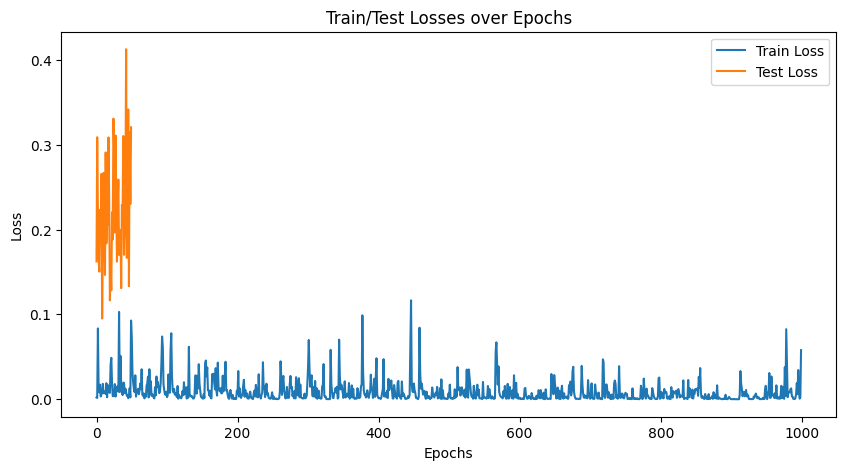

{'B': {'precision': 0.9834710743801653, 'recall': 0.9834710743801653, 'f1-score': 0.9834710743801653, 'support': 121}, 'M': {'precision': 0.9701492537313433, 'recall': 0.9701492537313433, 'f1-score': 0.9701492537313433, 'support': 67}, 'accuracy': 0.9787234042553191, 'macro avg': {'precision': 0.9768101640557543, 'recall': 0.9768101640557543, 'f1-score': 0.9768101640557543, 'support': 188}, 'weighted avg': {'precision': 0.9787234042553191, 'recall': 0.9787234042553191, 'f1-score': 0.9787234042553191, 'support': 188}}


In [97]:
import copy
best_report = None
best_model_weights = model.state_dict()
best_acc = 0.0
train_losses  = []
test_losses  = []
epochs = 1000

for epoch in range(epochs):
    model.train()
    epoch_train_loss_sum = 0 #tracks the sum of train losses processed in a single epoch
    epoch_train_samples = 0 #tracks the number of samples seen in a single epoch

    for X_train,y_train in train_loader:
        optimizer.zero_grad()
        y_train_pred = model(X_train)
        train_loss = loss_fn(y_train_pred,y_train)
        epoch_train_loss_sum += train_loss.item() * X_train.size(0)
        epoch_train_samples += X_train.size(0)
        train_loss.backward()
        optimizer.step()

    epoch_avg_train_loss = epoch_train_loss_sum / epoch_train_samples
    train_losses.append(epoch_avg_train_loss)

    if epoch % 20 ==0:
        epoch_test_loss_sum = 0
        epoch_test_samples = 0
        y_test_preds = []
        y_test_trues = []
        for X_test,y_test in test_loader:
            with torch.no_grad():
                model.eval()
                y_test_pred = model(X_test)
                test_loss  = loss_fn(y_test_pred, y_test)
                # Apply sigmoid function to output to get probabilities
                y_test_pred = torch.sigmoid(y_test_pred)
                # Apply threshold
                y_test_pred = (y_test_pred > 0.5).float()
                y_test_preds.extend(list(y_test_pred.numpy()))
                y_test_trues.extend(list(y_test.numpy()))
                epoch_test_loss_sum += test_loss.item() * X_test.size(0)
                epoch_test_samples += X_test.size(0)

        epoch_avg_test_loss = epoch_test_loss_sum / epoch_test_samples
        test_losses.append(epoch_avg_test_loss)
        report = classification_report(y_true=y_test_trues,y_pred=y_test_preds,target_names=["B","M"], output_dict=True,zero_division="warn")
        if report['accuracy'] > best_acc:
            best_acc = report['accuracy']
            best_report = report
            best_model_weights = copy.deepcopy(model.state_dict())



plt.figure(figsize=(10,5))
plt.title("Train/Test Losses over Epochs")
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.show()
print(best_report)


In [98]:
model.load_state_dict(best_model_weights)
torch.save(model.state_dict(),'Breast_Cancer_Classification_Model')